# Using GradCAM to identify adveserial attacks 
## FGSM implimentation from : https://www.tensorflow.org/tutorials/generative/adversarial_fgsm 

In [1]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt
import numpy as np
from explanation_models import gradcam

In [2]:
orig_img,img=imagenet_utils.load_test_img("both.png")

In [3]:
test=load_model('VGG16')
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [12]:
import tensorflow as tf
probs=model.predict(img)
print(tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=5))
print(np.argsort(-probs)[0][:5])

[[('n02108089', 'boxer', 0.42014065), ('n02108422', 'bull_mastiff', 0.28162318), ('n02123159', 'tiger_cat', 0.053449746), ('n02129604', 'tiger', 0.050134733), ('n02109047', 'Great_Dane', 0.04980786)]]
[242 243 282 292 246]


Text(0.5, 1.0, 'boxer(42.01%)')

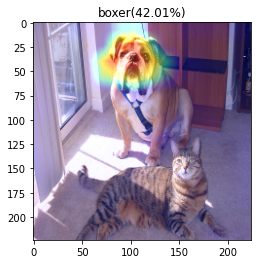

In [41]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img)
_,name,confidence=tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]
plt.title('{}({:.2f}%)'.format(name, confidence*100))

In [19]:

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.cast(input_image, tf.float32)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)

    return signed_grad

In [20]:
boxer=242
label = tf.one_hot(boxer, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))
perturbations = create_adversarial_pattern(img, label)


In [53]:
eps=0.8
adv_x = img + eps*perturbations

In [54]:
probs2=model.predict(adv_x)
print(tf.keras.applications.mobilenet_v2.decode_predictions(probs2, top=5))
print(np.argsort(-probs2)[0][:5])


[[('n02129604', 'tiger', 0.41019297), ('n02123159', 'tiger_cat', 0.1771361), ('n02108422', 'bull_mastiff', 0.072690405), ('n02106662', 'German_shepherd', 0.031165905), ('n02110958', 'pug', 0.028089106)]]
[292 282 243 235 254]


Text(0.5, 1.0, 'eps:0.8,tiger(41.02%)')

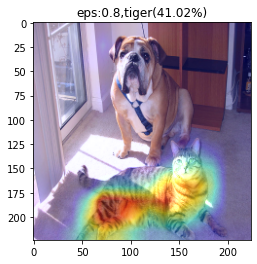

In [58]:
heatmap=g.get_heatmap(adv_x)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img)
_,name,confidence=tf.keras.applications.mobilenet_v2.decode_predictions(probs2, top=1)[0][0]
plt.title('eps:{},{}({:.2f}%)'.format(eps,name, confidence*100))

Text(0.5, 1.0, 'eps:0.8,boxer(0.55%)')

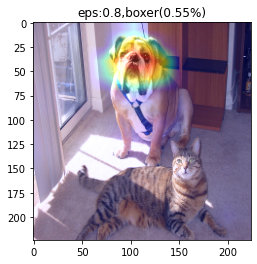

In [59]:
heatmap=g.get_heatmap(adv_x,242)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
plt.imshow(overlayed_img)
plt.title('eps:{},{}({:.2f}%)'.format(eps,'boxer', probs2[0][242]*100))